# Boing de 2015 à la crise de 2020

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [125]:
def get_stationarity(timeseries, window_size= 12 ):
    """
    Take a pandas serie timeseries in to output key indicators of stationarity
    """    
    # rolling statistics
    rolling_mean = timeseries.rolling(window= window_size).mean()
    rolling_std = timeseries.rolling(window= window_size).std()

    # rolling statistics plot
    fig= plt.figure(figsize= (15, 4))
    original = plt.plot(timeseries, color='black', label='Original', alpha= 0.3)
    mean = plt.plot(rolling_mean, color='coral', label='Rolling Mean')
    std = plt.plot(rolling_std, color='teal', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print("Mean MinMax Delta:", rolling_mean.max() - rolling_mean.min())
    print("Std MinMax Delta:", rolling_std.max() - rolling_std.min())
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [254]:
def plot_corr_function(df):
    """
    Take a pandas series and plot Auto-correlation function and Partial Auto-correlation
    """
    fig, ax = plt.subplots(2, 1, figsize= [8, 6])
    
    _ = plot_acf(df, color= 'blue', ax= ax[0])
    _ = plot_pacf(df, color= 'blue', ax= ax[1])# _ = est un truc pour éviter d'imprimer 2x le même plot

In [259]:
def tfrm_to_MinusMean(PdSeries, window_size= 12):
    """
    Transform a Pandas Series to stationary by substracting rolling mean from value.
    Returns a Pandas Series
    
    See why here: (https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7)
    """
    
    df_ravg = PdSeries.rolling(window_size).mean()
    df_minus_mean = PdSeries - df_ravg
    df_minus_mean.dropna(inplace=True)
    return df_minus_mean

In [2]:
BA = pd.read_csv('Aero_analysis - BA.csv', parse_dates= True)
BA.index = pd.to_datetime(BA.Date)
BA = BA.drop(columns= ['Date', 'Column1', 'Historical', 'Unnamed: 12', 'Unnamed: 13' ])

In [3]:
BA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2015-04-28 to 2020-04-27
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1259 non-null   float64
 1   High              1259 non-null   float64
 2   Low               1259 non-null   float64
 3   Close             1259 non-null   float64
 4   Adj Close         1259 non-null   float64
 5   Volume            1259 non-null   int64  
 6   Average           1259 non-null   float64
 7   Relative to mean  1259 non-null   float64
 8   % increase        1258 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 98.4 KB


In [4]:
BA.head()

,Open,High,Low,Close,Adj Close,Volume,Average,Relative to mean,% increase
Date,,,,,,,,,
2015-04-28,147.899994,148.369995,146.009995,147.509995,128.818481,4352900,147.189995,0.597664,0.207083
2015-04-29,147.070007,147.460007,145.899994,146.149994,127.630844,4761700,146.680000,0.595594,0.948126
2015-04-30,145.250000,145.940002,142.750000,143.339996,125.176880,4925300,144.345001,0.586112,-0.044666
2015-05-01,144.410004,145.070007,143.839996,144.669998,126.338371,3556800,144.455001,0.586559,0.190847
2015-05-04,143.850006,144.789993,143.179993,144.020004,125.770737,8977500,143.984993,0.584651,0.203022


### Boing de 2015 à 2019

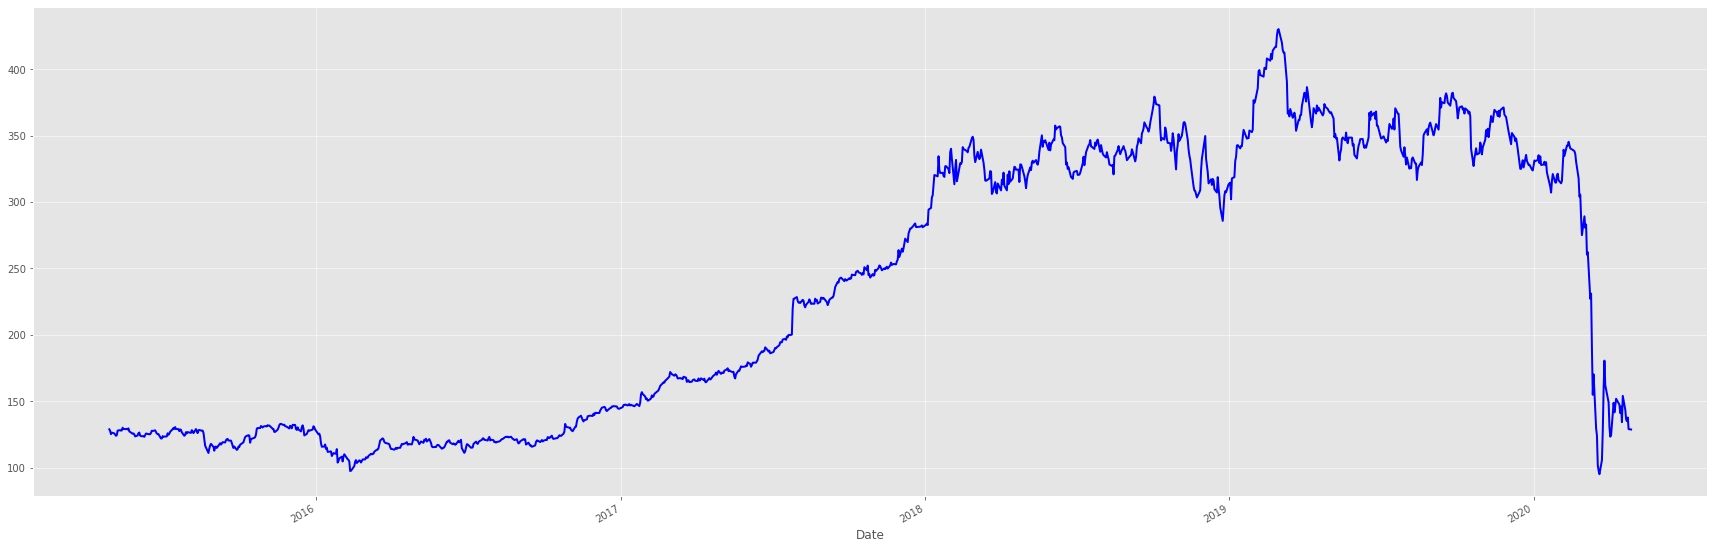

In [102]:
_ = BA['Adj Close'].plot(color= 'blue', figsize= [30, 10])

In [34]:
BA_diff = BA['Adj Close'].diff()
BA_diff.dropna(inplace= True)

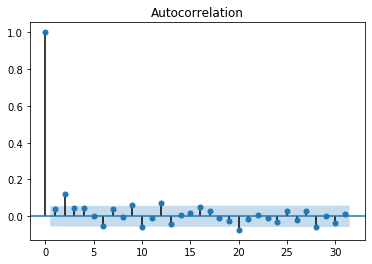

In [57]:
_ = plot_acf(BA_diff) # _ = est un truc pour éviter d'imprimer 2x le même plot

## Boing 2016 - Différenciation des valeurs

In [3]:
BA_2016 = BA.loc['2016']

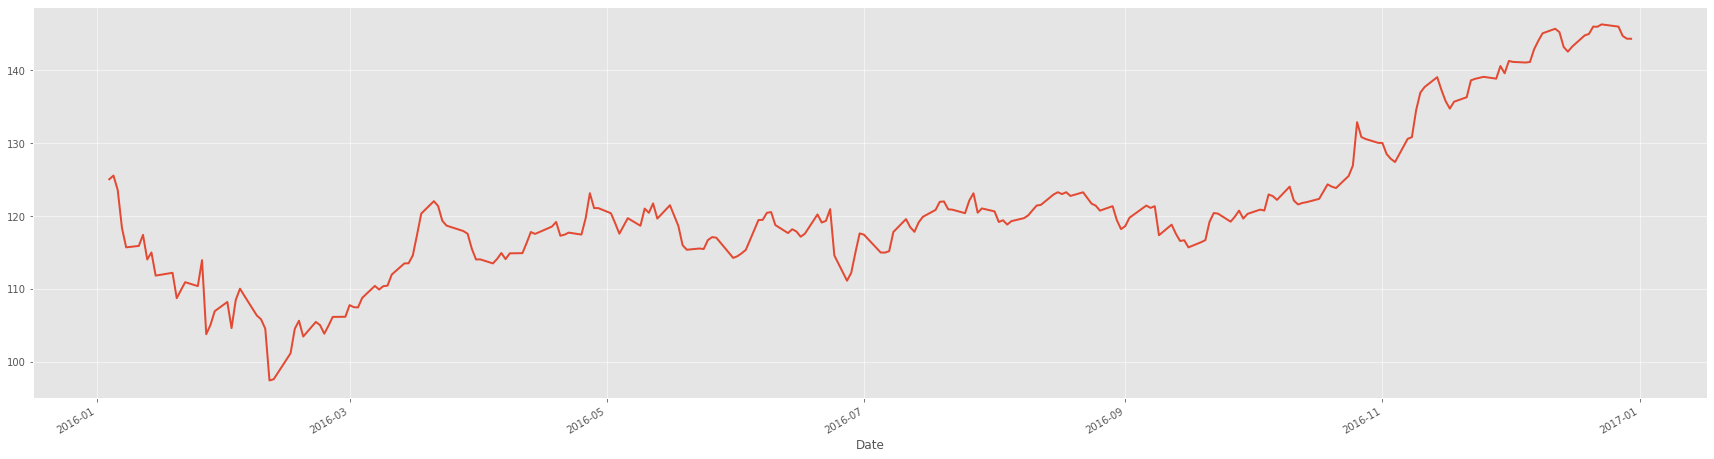

In [124]:
_ = BA_2016['Adj Close'].plot(figsize= [30, 8])

### Valeurs différenciées sur interval de 1 jours ("First difference")

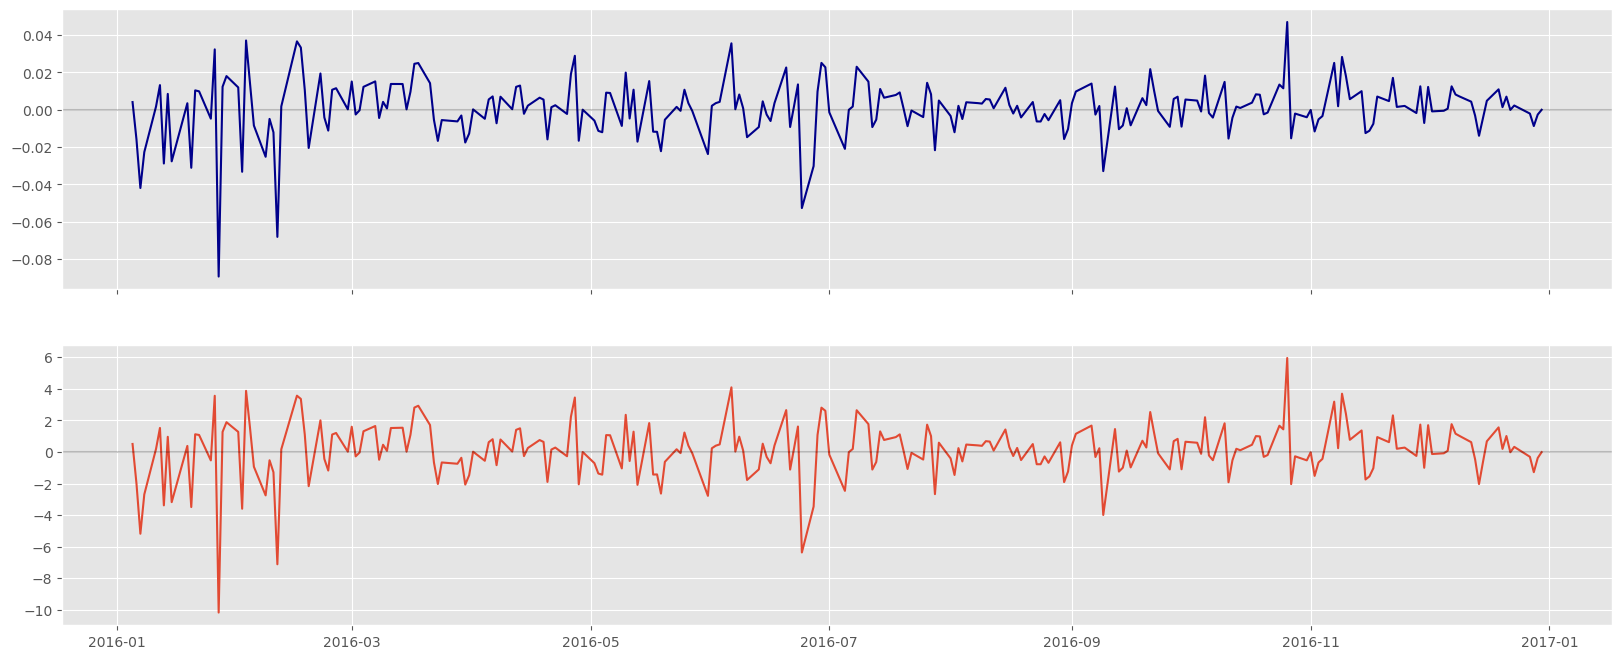

In [241]:
BA_2016_diff = BA_2016['Adj Close'].diff()
BA_2016_pct = BA_2016['Adj Close'].pct_change()
BA_2016_diff.dropna(inplace= True)

fig, ax = plt.subplots(2, 1, sharex= True, figsize= [20, 8])
plt.style.use("ggplot")

_ = ax[0].plot(BA_2016_pct.index, BA_2016_pct, color= 'darkblue')
_ = ax[1].plot(BA_2016_diff.index, BA_2016_diff)
_ = ax[0].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)
_ = ax[1].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)

#### Est-ce un random walk?

In [8]:
# Appliquer le Dickey-Fuller test pour voir si c'est un random walk.
adf = adfuller(BA_2016_diff)
# Cette valeur (p-value) @ moins de 0.05 permet de rejeter l'hypothèse nul
adf[1]

1.3028801661300641e-13

L'hypothèse nul peut être rejetée. 
Le court de Boing n'est `PAS`un random walk.

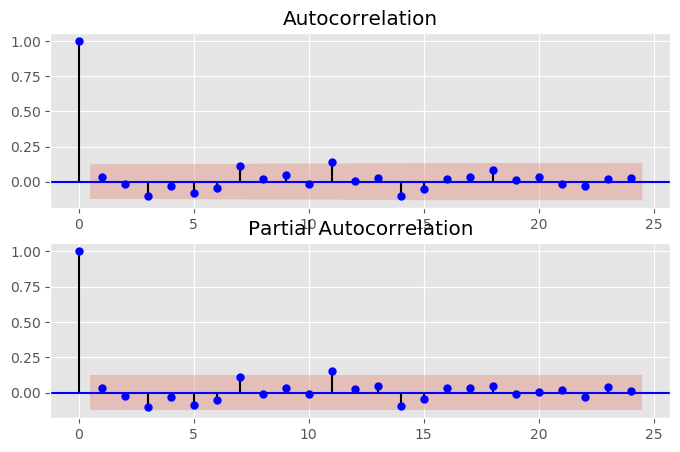

In [251]:
plot_corr_function(BA_2016_diff)

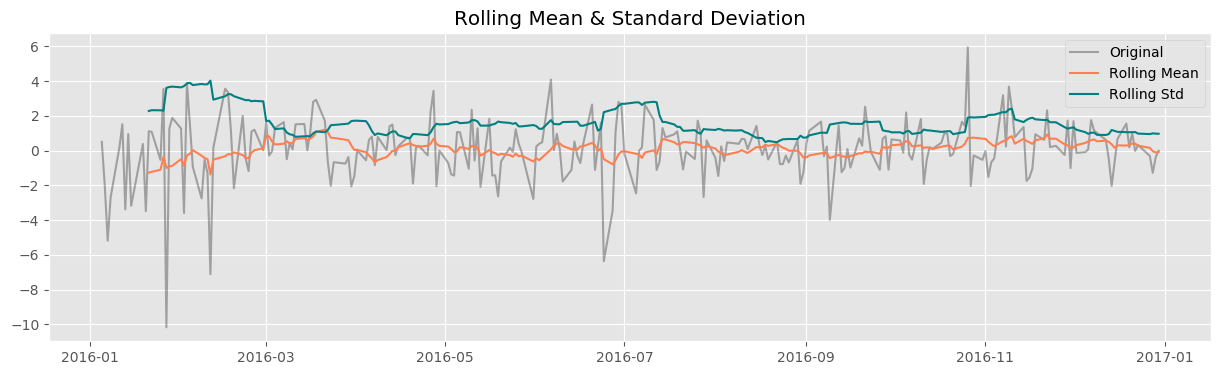

Mean MinMax Delta: 2.593256666666666
Std MinMax Delta: 3.5468380417145067
ADF Statistic: -8.492386834587538
p-value: 1.3028801661300641e-13
Critical Values:
	1%: -3.457215237265747
	5%: -2.873361841566324
	10%: -2.5730700760129555


In [242]:
get_stationarity(BA_2016_diff)

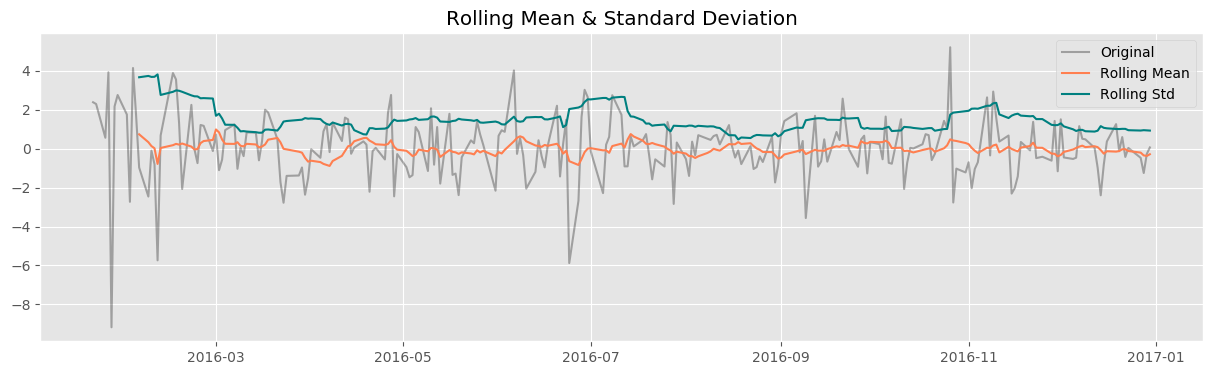

Mean MinMax Delta: 1.8759496875000017
Std MinMax Delta: 3.343113490587657
ADF Statistic: -9.494576988261562
p-value: 3.577369551658795e-16
Critical Values:
	1%: -3.4583663275730476
	5%: -2.8738660999177132
	10%: -2.5733390785693766


In [260]:
# Transform to stationary x - rolling mean
BA_2016_diff_minus_mean = tfrm_to_MinusMean(BA_2016_diff)
# Assess transformed dataset performances
get_stationarity(BA_2016_diff_minus_mean)

L'échantillon 2016 différencier de 1 - le rolling avg est hautement stationnaire.

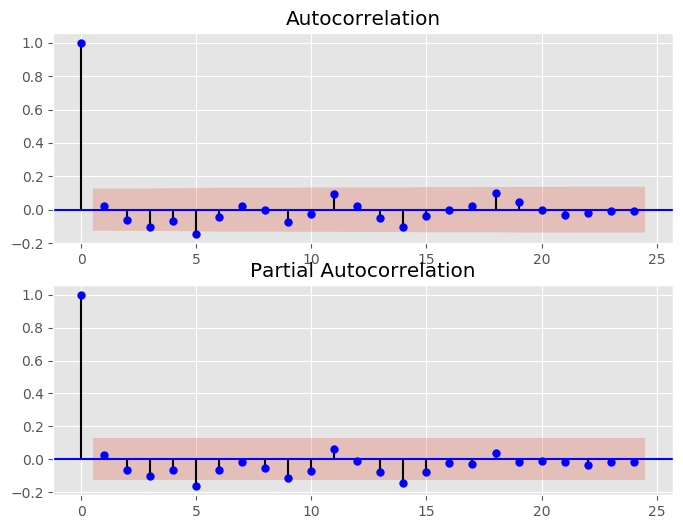

In [255]:
plot_corr_function(BA_2016_diff_minus_mean)

L'échantillon 2016 différencier de 1 - le rolling avg 
n'a aucune auto-corellation significative. L'ordre de AR optimal n'est donc pas important (Partial Autocorrolation).

### Valeurs différenciées sur interval de 4 jours

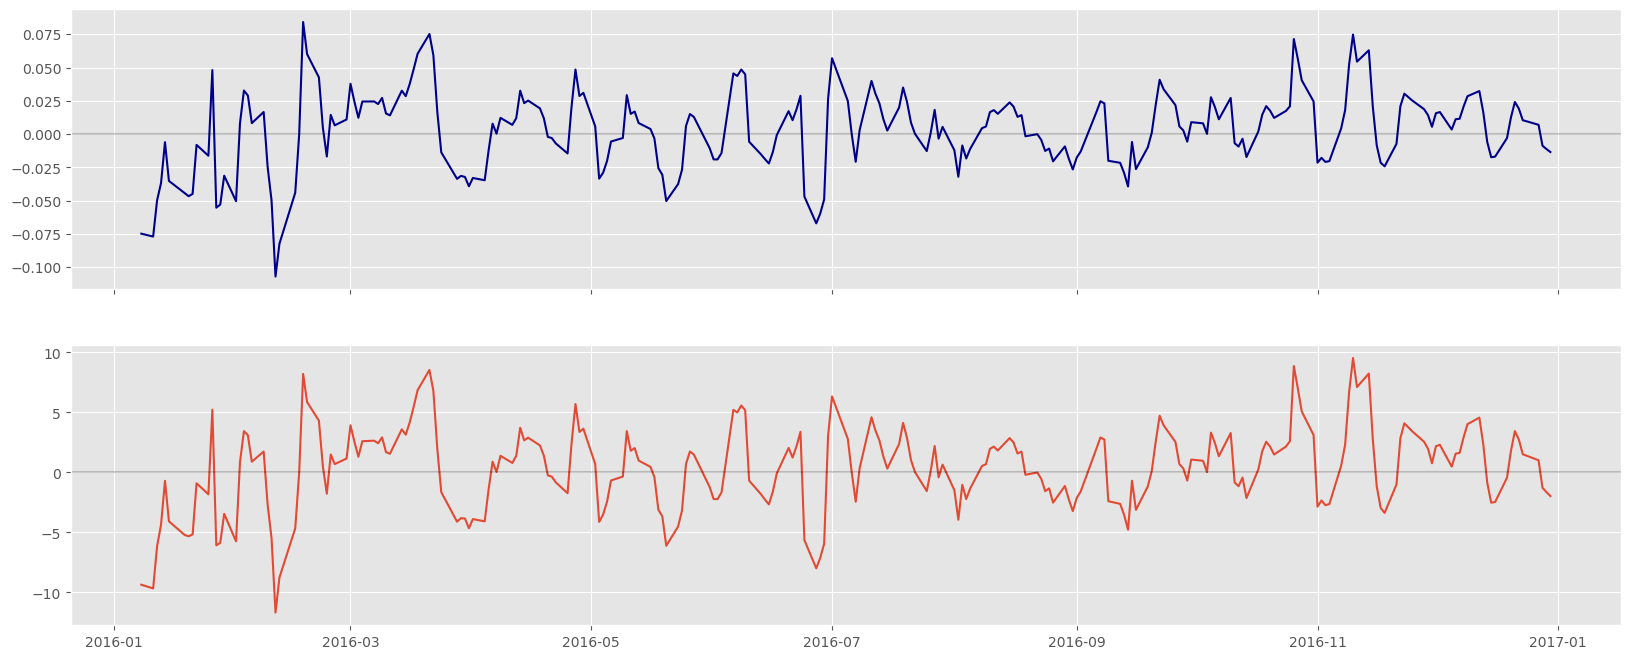

In [247]:
BA_2016_diff4 = BA_2016['Adj Close'].diff(4)
BA_2016_pct4 = BA_2016['Adj Close'].pct_change(4)
BA_2016_diff4.dropna(inplace= True)

fig, ax = plt.subplots(2, 1, sharex= True, figsize= [20, 8])
plt.style.use("ggplot")

_ = ax[0].plot(BA_2016_pct4.index, BA_2016_pct4, color= 'darkblue')
_ = ax[1].plot(BA_2016_diff4.index, BA_2016_diff4)
_ = ax[0].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)
_ = ax[1].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)

#### Est-ce un random walk?

In [32]:
# Appliquer le Dickey-Fuller test pour voir si c'est un random walk.
adf = adfuller(BA_2016_diff4)
# Cette valeur (p-value) @ moins de 0.05 permet de rejeter l'hypothèse nul
adf[1]

0.0061008302093181945

L'hypothèse nul peut être rejetée. 
Le court de Boing diff 4 n'est `PAS`un random walk.

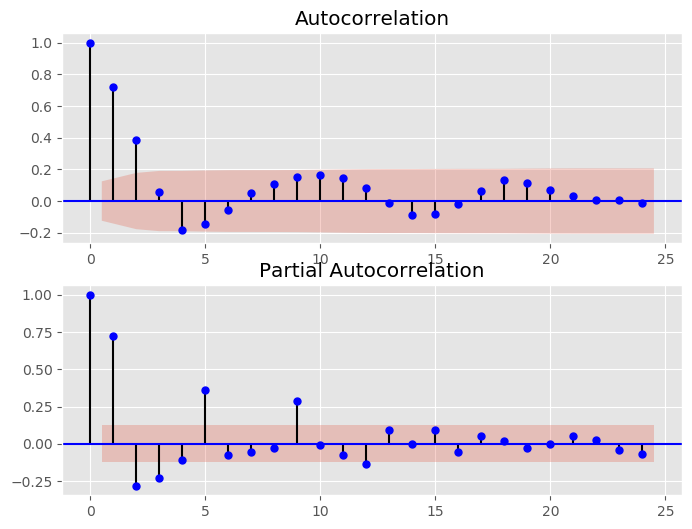

In [256]:
plot_corr_function(BA_2016_diff4)

### Valeurs différenciées sur interval de 5 jours

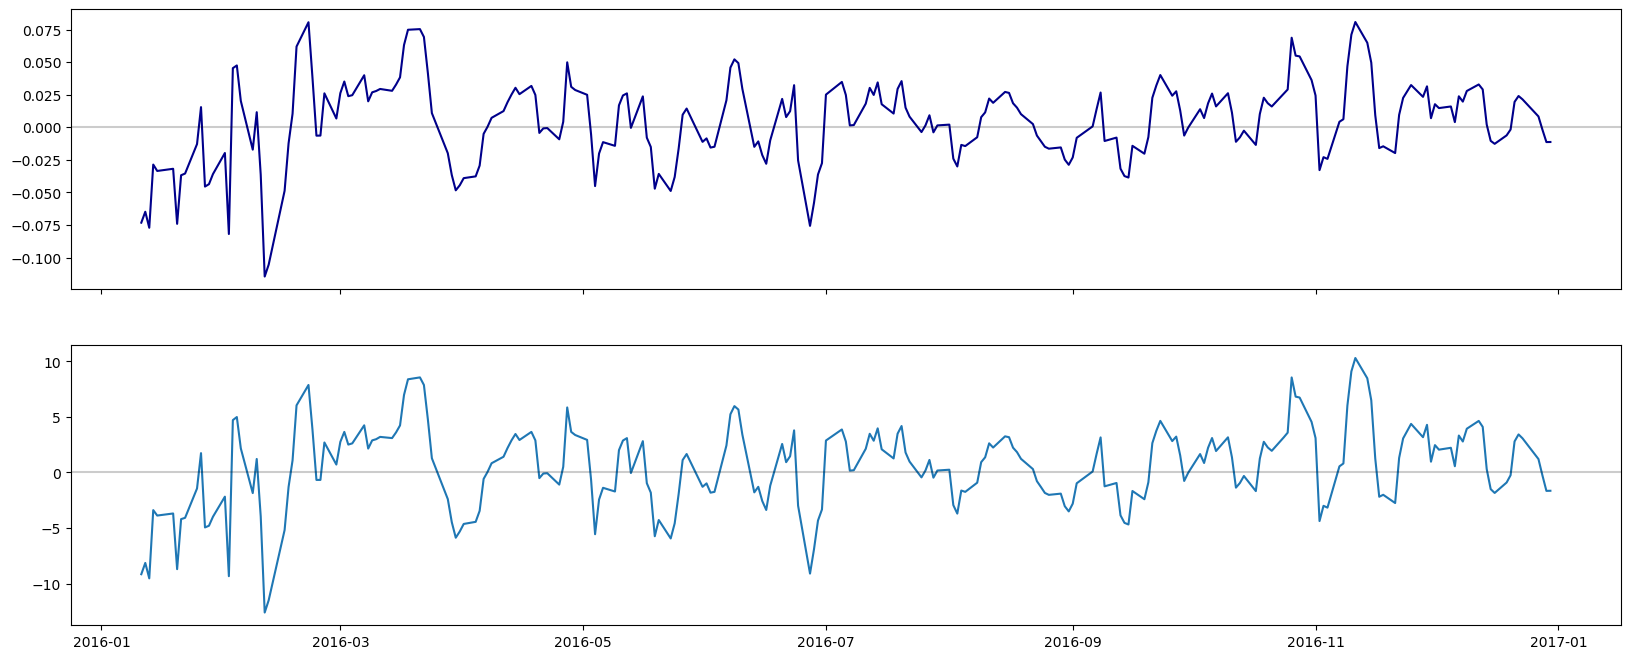

In [107]:
BA_2016_diff5 = BA_2016['Adj Close'].diff(5)
BA_2016_diff5.dropna(inplace= True)
BA_2016_pct5 = BA_2016['Adj Close'].pct_change(5)
BA_2016_pct5.dropna(inplace= True)

fig, ax = plt.subplots(2, 1, sharex= True, figsize= [20, 8])
plt.style.use("ggplot")

_ = ax[0].plot(BA_2016_pct5.index, BA_2016_pct5, color= 'darkblue')
_ = ax[1].plot(BA_2016_diff5.index, BA_2016_diff5)
_ = ax[0].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)
_ = ax[1].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)

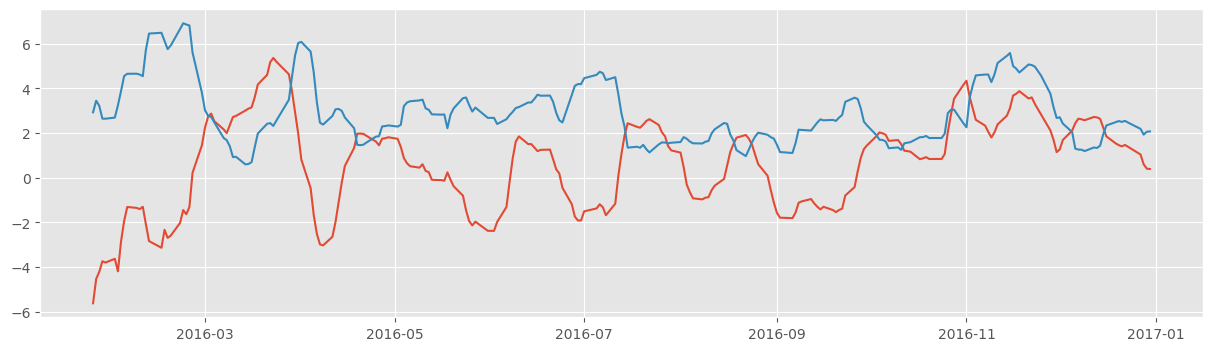

In [122]:
# See get_stationarity function below for more complete output.
BA_2016_diff5_ravg = BA_2016_diff5.rolling(10).mean()
BA_2016_diff5_rstd = BA_2016_diff5.rolling(10).std()
fig= plt.figure(figsize= (15, 4))
_ = plt.plot(BA_2016_diff5_ravg)
_ = plt.plot(BA_2016_diff5_rstd)

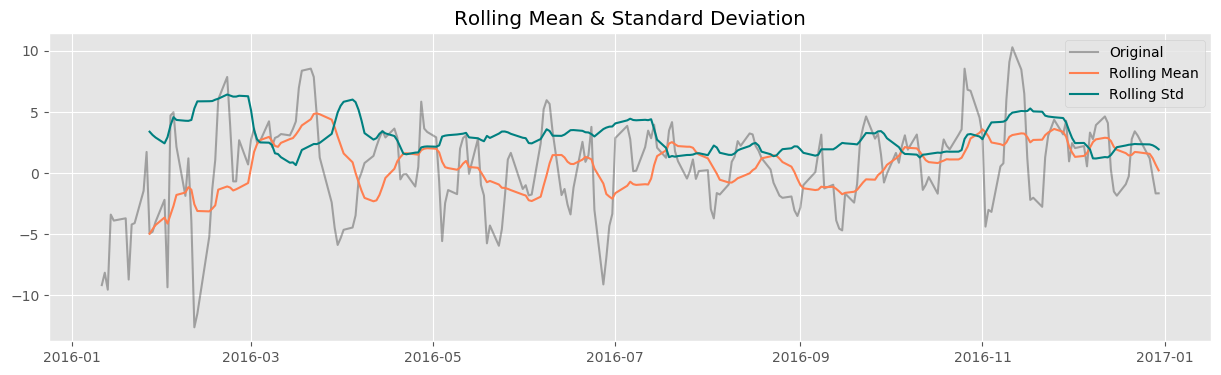

Mean MinMax Delta: 9.84178491666667
Std MinMax Delta: 5.7737074855308865
ADF Statistic: -3.1125524894856347
p-value: 0.025638086881736712
Critical Values:
	1%: -3.459105583381277
	5%: -2.8741898504150574
	10%: -2.5735117958412097


In [127]:
get_stationarity(BA_2016_diff5)

### Diff5 minus rolling mean transformation

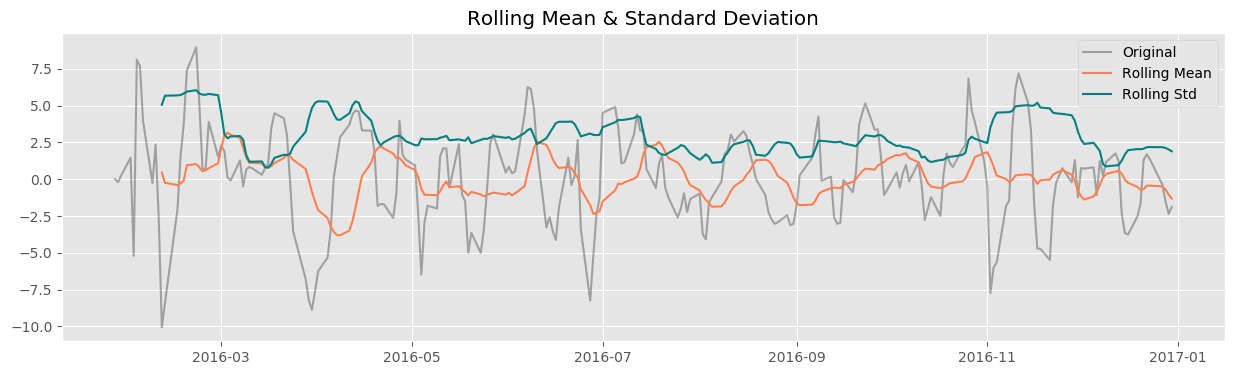

Mean MinMax Delta: 6.963335930555557
Std MinMax Delta: 5.249353753540705
ADF Statistic: -4.114861692121513
p-value: 0.0009151681389278011
Critical Values:
	1%: -3.4604283689894815
	5%: -2.874768966942149
	10%: -2.57382076446281


In [262]:
# Transform to stationary x - rolling mean
BA_2016_diff5_minus_mean = tfrm_to_MinusMean(BA_2016_diff5)
# Assess transformed dataset performances
get_stationarity(BA_2016_diff5_minus_mean)

#### Est-ce un random walk?

In [11]:
# Appliquer le Dickey-Fuller test pour voir si c'est un random walk.
adf = adfuller(BA_2016_diff5)
# Cette valeur (p-value) @ moins de 0.05 permet de rejeter l'hypothèse nul
adf[1]

0.025638086881736712

L'hypothèse nul peut être rejetée. 
Le court de Boing diff 5 n'est `PAS`un random walk.

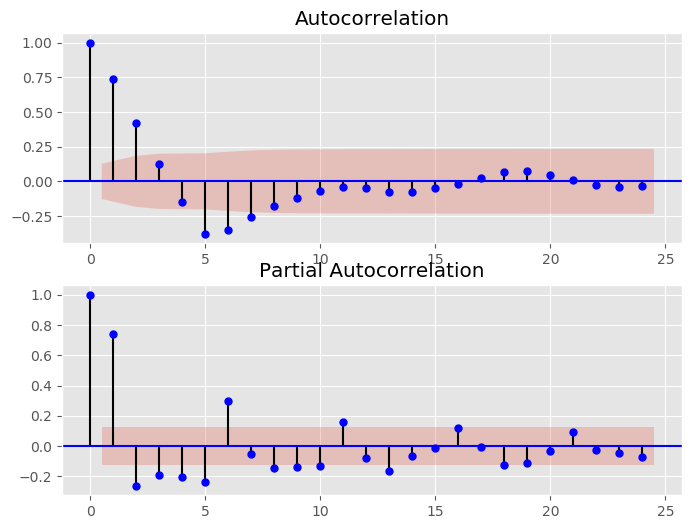

In [257]:
plot_corr_function(BA_2016_diff5_minus_mean)

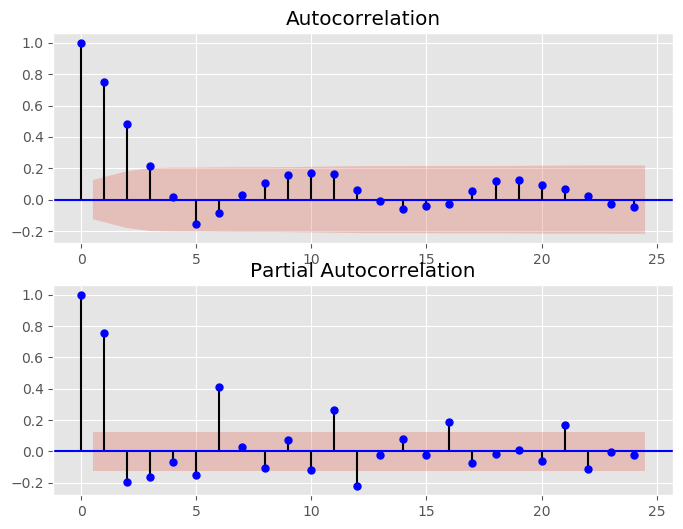

In [261]:
plot_corr_function(BA_2016_diff5)

### Diff5 avec Exponential decay

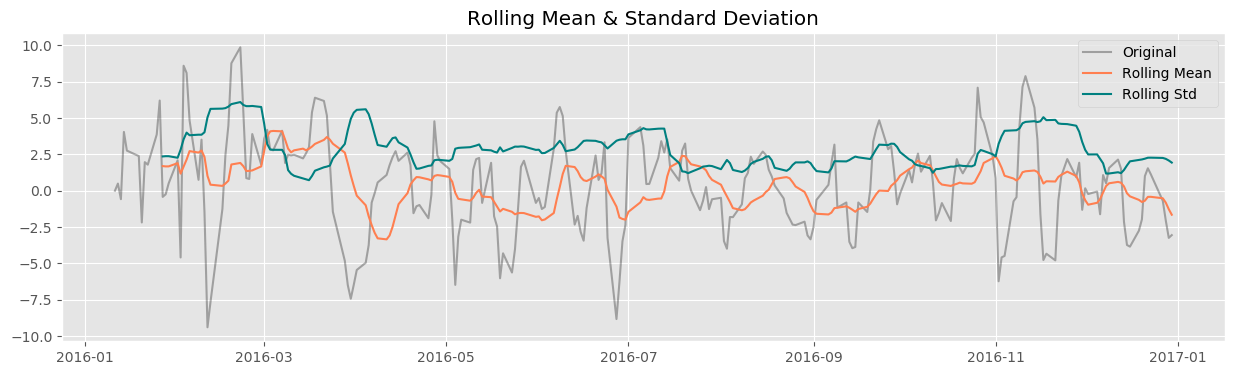

Mean MinMax Delta: 7.462389047213472
Std MinMax Delta: 5.376747722422954
ADF Statistic: -3.4156251721010005
p-value: 0.010437604402930399
Critical Values:
	1%: -3.459105583381277
	5%: -2.8741898504150574
	10%: -2.5735117958412097


In [263]:
rolling_mean_exp_decay = BA_2016_diff5.ewm(halflife=12, min_periods=0, adjust=True).mean()
BA_2016_diff5_exp_decay = BA_2016_diff5 - rolling_mean_exp_decay
BA_2016_diff5_exp_decay.dropna(inplace=True)
get_stationarity(BA_2016_diff5_exp_decay)

### Log + exponential decay

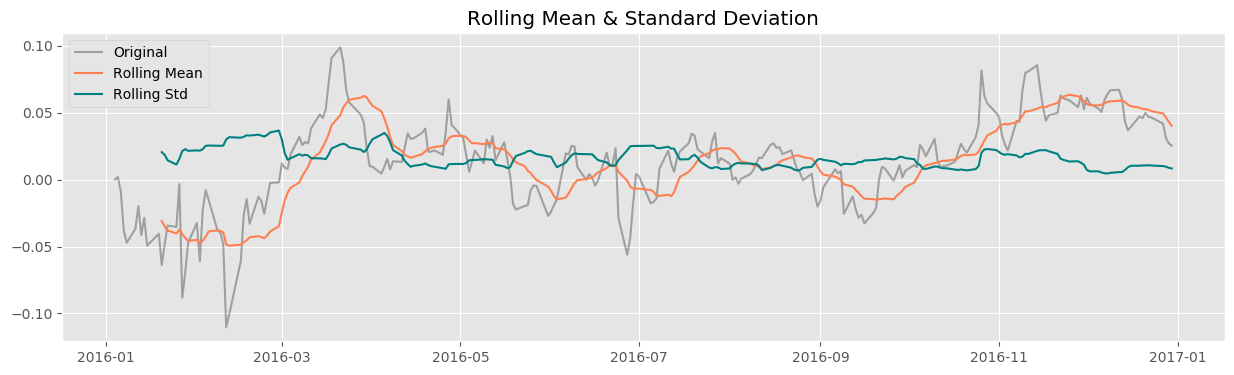

Mean MinMax Delta: 0.11277377173798309
Std MinMax Delta: 0.03205387309402805
ADF Statistic: -2.5150829147004607
p-value: 0.11184748603963374
Critical Values:
	1%: -3.457215237265747
	5%: -2.873361841566324
	10%: -2.5730700760129555


In [272]:
BA_2016_diff_log = np.log(BA_2016['Adj Close'])
rolling_mean_exp_decay = BA_2016_diff_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
BA_2016_diff_log_exp_decay = BA_2016_diff_log - rolling_mean_exp_decay
#BA_2016_diff_log_exp_decay.dropna(inplace=True)
get_stationarity(BA_2016_diff_log_exp_decay)

### Akaike Information Criterion

In [169]:
def AIC(PdSeries, order= (1,1)):
    """
    Take a Pandas series and fit an ARMA model of order= 
    to return Akaike Information Criterion
    """

    # Fit the data to an AR(1) model and print AIC:
    mod_arma = ARMA(PdSeries, order= order)
    res_arma = mod_arma.fit()
    print("The AIC for an ARMA{} is: ".format(order), res_arma.aic)
    return res_arma.aic

In [113]:
#BA_2016_diff5.index = pd.DatetimeIndex(BA_2016_diff5.index).to_period('W') # Nécessaire pour forcaster

print('BA_2016 différencier de 5')

# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARMA(BA_2016_diff5, order=(1, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

mod_ar2 = ARMA(BA_2016_diff5, order=(2, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

mod_ar6 = ARMA(BA_2016_diff5, order=(6, 0))
res_ar6 = mod_ar6.fit()
print("The AIC for an AR(6) is: ", res_ar6.aic)

mod_arma11 = ARMA(BA_2016_diff5, order=(1, 1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

mod_arma61 = ARMA(BA_2016_diff5, order=(6, 1))
res_arma61 = mod_arma61.fit()
print("The AIC for an ARMA(6,1) is: ", res_arma61.aic)

mod_arma62 = ARMA(BA_2016_diff5, order=(6, 2))
res_arma62 = mod_arma62.fit()
print("The AIC for an ARMA(6,2) is: ", res_arma62.aic)

mod_arma63 = ARMA(BA_2016_diff5, order=(6, 3))
res_arma63 = mod_arma63.fit()
print("The AIC for an ARMA(6,3) is: ", res_arma63.aic)
print(res_arma63.arparams)

mod_arma33 = ARMA(BA_2016_diff5, order=(3, 3))
res_arma33 = mod_arma33.fit()
print("The AIC for an ARMA(3,3) is: ", res_arma33.aic)

BA_2016 différencier de 5
The AIC for an AR(1) is:  1145.5308415039026
The AIC for an AR(2) is:  1138.3005779228124
The AIC for an AR(6) is:  1083.564705386519
The AIC for an ARMA(1,1) is:  1140.9819730565198
The AIC for an ARMA(6,1) is:  1085.0335987102546
The AIC for an ARMA(6,2) is:  1069.0317039842066
The AIC for an ARMA(6,3) is:  1060.366381158427
[ 0.89060717 -0.50565721 -0.03816783  0.33718405 -0.48092617  0.2857437 ]
The AIC for an ARMA(3,3) is:  1084.6356989882916


In [154]:
print('BA_2016 différencier de 5 moins le rolling average', '\n')

AIC(BA_2016_diff5_minus_mean, order=(1, 0))
AIC(BA_2016_diff5_minus_mean, order=(2, 0))
AIC(BA_2016_diff5_minus_mean, order=(2, 3))
AIC(BA_2016_diff5_minus_mean, order=(6, 0))
AIC(BA_2016_diff5_minus_mean, order=(1, 1))
AIC(BA_2016_diff5_minus_mean, order=(6, 1))
AIC(BA_2016_diff5_minus_mean, order=(6, 2))
AIC(BA_2016_diff5_minus_mean, order=(6, 3))
AIC(BA_2016_diff5_minus_mean, order=(3, 3))
AIC(BA_2016_diff5_minus_mean, order=(11, 3))

BA_2016 différencier de 5 moins le rolling average 

The AIC for an ARMA(1, 0) is:  1053.7054248678692
The AIC for an ARMA(2, 0) is:  1039.650592835645
The AIC for an ARMA(2, 3) is:  995.3496742053321
The AIC for an ARMA(6, 0) is:  987.6906772037416
The AIC for an ARMA(1, 1) is:  1044.900164530271
The AIC for an ARMA(6, 1) is:  988.3477913684085
The AIC for an ARMA(6, 2) is:  988.84843654972
The AIC for an ARMA(6, 3) is:  963.4510328419624
The AIC for an ARMA(3, 3) is:  994.2952381372523
The AIC for an ARMA(11, 3) is:  955.1772487516348


In [155]:
AIC(BA_2016_diff5_minus_mean, order=(11, 2))

The AIC for an ARMA(11, 2) is:  954.85719355781


In [159]:
AIC(BA_2016_diff5_minus_mean, order=(11, 3))

The AIC for an ARMA(11, 3) is:  955.1772487516348


In [165]:
AIC(BA_2016_diff5_minus_mean, order=(1, 6))

The AIC for an ARMA(1, 6) is:  914.115884906586


In [190]:
def aic_optimize(PdSeries, ar_max_range= 8, ma_max_range= 12):
    """
    Take Pandas series and print Akaike Information Criterion for every order in 
    a range of order, ar(0) to ar(ar_max_range) and ma(0) to ma(ma_max_range).
    Also return a list of all AIC values. 
    """
    ar_ls= np.arange(0, ar_max_range)
    ma_ls= np.arange(0, ma_max_range)
    aic_ls= []
    for i in ar_ls:
        for j in ma_ls:
            aic = AIC(PdSeries, order= (i, j))
            aic
            aic_ls.append(aic)
    return aic_ls

In [214]:
aic_16_5_mean = aic_optimize(BA_2016_diff5_minus_mean, ar_max_range= 5, ma_max_range= 11)

The AIC for an ARMA(0, 0) is:  1236.018424050823
The AIC for an ARMA(0, 1) is:  1106.412676689985
The AIC for an ARMA(0, 2) is:  1047.1949815402954
The AIC for an ARMA(0, 3) is:  1048.2971155450507
The AIC for an ARMA(0, 4) is:  927.9627378702845
The AIC for an ARMA(0, 5) is:  929.6480085585262
The AIC for an ARMA(0, 6) is:  929.2243382073832
The AIC for an ARMA(0, 7) is:  926.6007610471338
The AIC for an ARMA(0, 8) is:  927.1645948640511
The AIC for an ARMA(0, 9) is:  918.8403562146646
The AIC for an ARMA(0, 10) is:  920.3563364229168
The AIC for an ARMA(1, 0) is:  1053.7054248678692
The AIC for an ARMA(1, 1) is:  1044.900164530271
The AIC for an ARMA(1, 2) is:  1043.2865752144883
The AIC for an ARMA(1, 3) is:  1030.683250590606
The AIC for an ARMA(1, 4) is:  929.7113556273231
The AIC for an ARMA(1, 5) is:  913.1076832877095
The AIC for an ARMA(1, 6) is:  914.115884906586
The AIC for an ARMA(1, 7) is:  916.059163348199
The AIC for an ARMA(1, 8) is:  918.0541296333613
The AIC for an AR

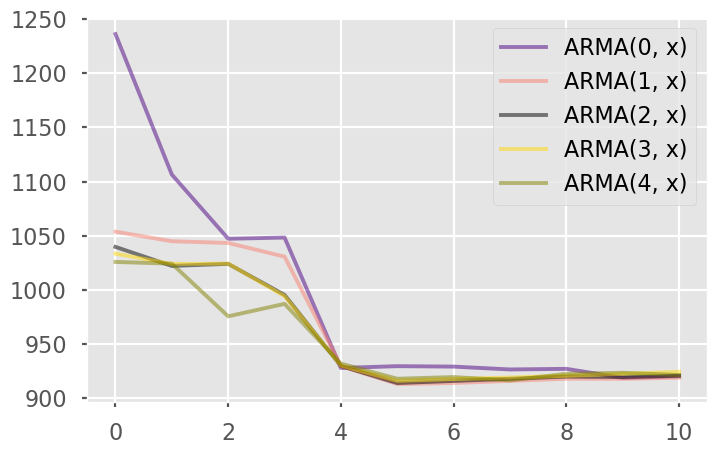

In [227]:
plt.figure(figsize= (8, 5))
_= plt.plot(aic_16_5_mean[0:11], color='indigo', label='ARMA(0, x)', alpha= 0.5)
_= plt.plot(aic_16_5_mean[11:22], color='salmon', label='ARMA(1, x)', alpha= 0.5)
_= plt.plot(aic_16_5_mean[22:33], color='black', label='ARMA(2, x)', alpha= 0.5)
_= plt.plot(aic_16_5_mean[33:44], color='gold', label='ARMA(3, x)', alpha= 0.5)
_= plt.plot(aic_16_5_mean[44:55], color='olive', label='ARMA(4, x)', alpha= 0.5)
_= plt.legend(loc='best')

In [31]:
x = len(BA_2016_diff5)
df =  BA_2016_diff5.reset_index()
df['num_index'] = range(0,x,1)
df = df.set_index(df['num_index'])
df.drop(columns= ['Date', 'num_index'], inplace= True)
df.dropna(inplace= True)

/anaconda3/envs/FinBoys/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/anaconda3/envs/FinBoys/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


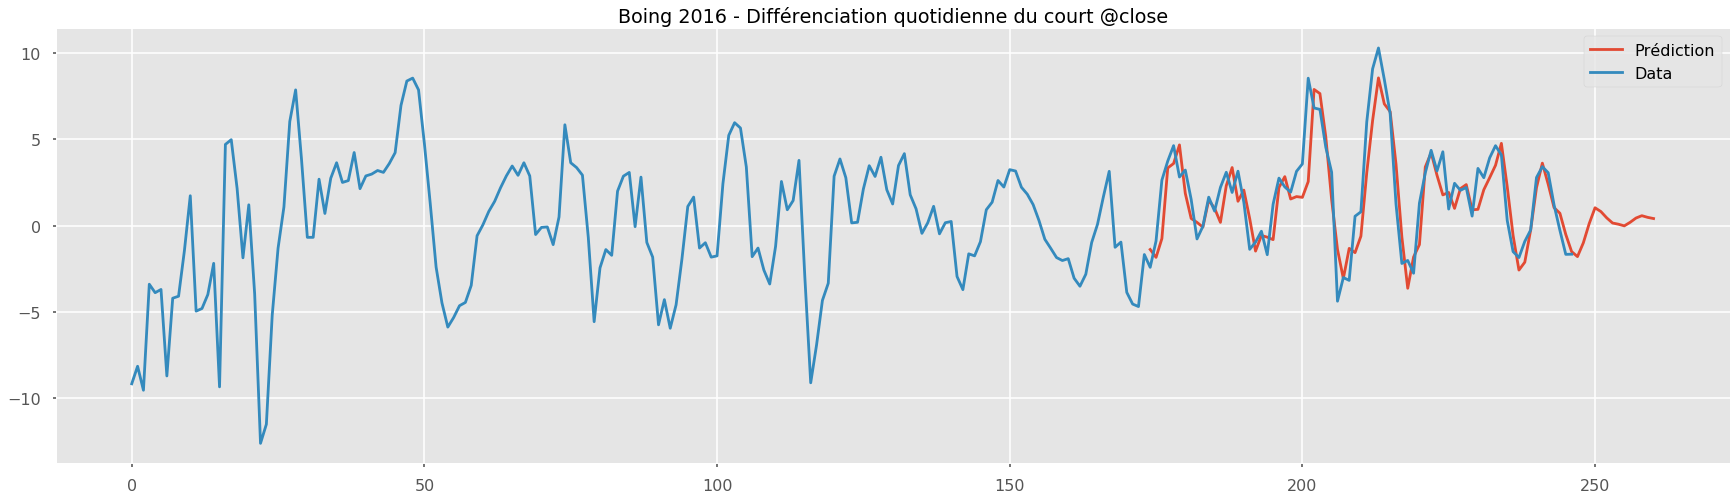

In [63]:
# Forecast price using an ARMA(6,3) model
mod_arma63 = ARMA(BA_2016_diff5, order=(6, 3))
res_arma63 = mod_arma63.fit()

pred_arma63 = res_arma63.predict(start='2016-09-19', end=260 )

# Plot the original series and the forecasted series
plt.style.use("seaborn-poster")
fig= plt.figure(figsize= (30, 8))
ax= fig.add_subplot(111)
ax.set(title= 'Boing 2016 - Différenciation quotidienne du court @close')
ax.plot(pred_arma63, label= 'Prédiction')
ax.plot(df, label= 'Data')
ax.legend()
#pred_arma63.tail(8)
_ = plt.show()

In [42]:
BA_2016_diff5.max()

10.29576800000001

In [56]:
pred_arma63.head()

174   -1.377480
175   -1.834499
176   -0.745910
177    3.346348
178    3.603579
dtype: float64

In [273]:
def rolling_window(a, step):
    shape   = a.shape[:-1] + (a.shape[-1] - step + 1, step)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [319]:
r = rolling_window(np.array(BA_2016_diff5_minus_mean), 100)
r.shape

(137, 100)

In [320]:
r

array([[ 5.16516667e-03, -2.06910417e-01,  2.56599833e-01, ...,
        -3.50361958e+00, -4.13599075e+00, -1.93626375e+00],
       [-2.06910417e-01,  2.56599833e-01,  1.45064200e+00, ...,
        -4.13599075e+00, -1.93626375e+00,  1.45636142e+00],
       [ 2.56599833e-01,  1.45064200e+00, -5.20922742e+00, ...,
        -1.93626375e+00,  1.45636142e+00, -4.05236667e-01],
       ...,
       [-1.59204667e-01,  1.69255942e+00,  1.98219583e+00, ...,
         1.35825658e+00, -3.73984000e-01, -1.49806558e+00],
       [ 1.69255942e+00,  1.98219583e+00,  3.03329667e+00, ...,
        -3.73984000e-01, -1.49806558e+00, -2.36417775e+00],
       [ 1.98219583e+00,  3.03329667e+00,  2.56071983e+00, ...,
        -1.49806558e+00, -2.36417775e+00, -1.87594867e+00]])

In [321]:
print(r[0][0])
print(r[1][0])
print(r[2][0])
print(r[3][0])

0.005165166666661669
-0.20691041666666354
0.2565998333333406
1.4506420000000113


In [322]:
BA_2016_diff5_minus_mean.head()

Date
2016-01-27    0.005165
2016-01-28   -0.206910
2016-01-29    0.256600
2016-02-01    1.450642
2016-02-02   -5.209227
Name: Adj Close, dtype: float64

In [281]:
BA_2016_diff5_minus_mean.shape

(236,)

In [331]:
# print(r[0][0:10])
print(BA_2016_diff5_minus_mean.iloc[99:110])

Date
2016-06-17   -1.936264
2016-06-20    1.456361
2016-06-21   -0.405237
2016-06-22    0.209799
2016-06-23    2.657725
2016-06-24   -3.369320
2016-06-27   -8.251554
2016-06-28   -5.200714
2016-06-29   -2.408697
2016-06-30   -1.242831
2016-07-01    4.506481
Name: Adj Close, dtype: float64


In [324]:
mod_arma_t = ARMA(r[0], order= (1,5))
res_arma_t = mod_arma_t.fit()
pred_arma_t = res_arma_t.predict(end= len(r[0]) + 1)
print(pred_arma_t[101])

-0.2620739346539049


In [332]:
print(pred_arma_t[101])

0.5077490651127041


In [325]:
r = rolling_window(np.array(BA_2016_diff5_minus_mean), 100)

for i in r:
    mod_arma_t = ARMA(i, order= (1,5))
    res_arma_t = mod_arma_t.fit()

    # Predict  days after training
    pred_arma_t = res_arma_t.predict(end= len(i) + 1)
    print(pred_arma_t[101])

-0.2620739346539049
0.3751518176992303
0.601877478366997
1.0096629606486593
-0.5925456216934799
-4.2193723397663785
-4.851671419332577
-3.7622214748194702
-2.9985719460720572
3.5561248360824225
5.842604713221221
2.8572407148533863
0.48526357472975673
0.48996880103224183
0.5077490651127041


ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [310]:
# no de jour dans l'année où s'arrête le training set
trainset_end = 100 

# Define training data
BA_2016_diff5_minus_mean_train = BA_2016_diff5_minus_mean.iloc[0:trainset_end]
BA_2016_diff5_minus_mean_train.dropna(inplace= True)
print(BA_2016_diff5_minus_mean_train)

# Forecast price using an ARMA(6,3) model
mod_arma63_t = ARMA(BA_2016_diff5_minus_mean_train, order=(1, 5))
res_arma63_t = mod_arma63_t.fit()

# Predict 5 days after training
pred_arma63_t = res_arma63_t.predict(end= 101)
print(pred_arma63_t[101])

Date
2016-01-27    0.005165
2016-01-28   -0.206910
2016-01-29    0.256600
2016-02-01    1.450642
2016-02-02   -5.209227
                ...   
2016-06-13   -3.277978
2016-06-14   -2.579208
2016-06-15   -3.503620
2016-06-16   -4.135991
2016-06-17   -1.936264
Name: Adj Close, Length: 100, dtype: float64
-0.2620739346539049


In [ ]:
def Roll_stpp_ARMA(PdSeries, window_size= 100, order= (1,1), dp_pred= 5, title= 'Boing 2016 - Différenciation quotidienne du court @close'):
    """
    Split, Train, Predict, Plot
    Split a Pandas series to train an ARMA model and plot prediction beyond the end of training data against observed data.
    """

    # Define training data
    df_train = PdSeries.rolling(window_size)
    #df_train.dropna(inplace= True)
    
    """
    x = len(PdSeries)
    df =  PdSeries.reset_index()
    df['num_index'] = range(0,x,1)
    df = df.set_index(df['num_index'])
    df.drop(columns= ['Date', 'num_index'], inplace= True)
    df.dropna(inplace= True)
    """
    
    # Forecast price using an ARMA(6,3) model
    mod_arma_t = ARMA(df_train, order= order)
    res_arma_t = mod_arma_t.fit()

    # Predict 5 days after training
    pred_arma_t = res_arma_t.predict(end= len(df_train) + dp_pred)

    # Plot the original series and the forecasted series
    plt.style.use("seaborn-poster")
    fig= plt.figure(figsize= (30, 8))
    ax= fig.add_subplot(111)
    ax.set(title= title)
    ax.plot(pred_arma_t, label= 'Prédiction') # Prediction
    ax.plot(df, label= 'Data') # Actual data
    ax.axvline(x= trainset_end, linestyle='-', color='k', alpha= 0.2) # Vertical line to mark where prediction starts
    ax.legend()

    _ = plt.show()

In [232]:
def stpp_ARMA(PdSeries, trainset_end= 150, order= (1,1), dp_pred= 5, title= 'Boing 2016 - Différenciation quotidienne du court @close'):
    """
    Split, Train, Predict, Plot
    Split a Pandas series to train an ARMA model and plot prediction beyond the end of training data against observed data.
    """

    # Define training data
    df_train = PdSeries.iloc[0:trainset_end]
    df_train.dropna(inplace= True)

    x = len(PdSeries)
    df =  PdSeries.reset_index()
    df['num_index'] = range(0,x,1)
    df = df.set_index(df['num_index'])
    df.drop(columns= ['Date', 'num_index'], inplace= True)
    df.dropna(inplace= True)
    
    # Forecast price using an ARMA(6,3) model
    mod_arma_t = ARMA(df_train, order= order)
    res_arma_t = mod_arma_t.fit()

    # Predict 5 days after training
    pred_arma_t = res_arma_t.predict(end= trainset_end + dp_pred)

    # Plot the original series and the forecasted series
    plt.style.use("seaborn-poster")
    fig= plt.figure(figsize= (30, 8))
    ax= fig.add_subplot(111)
    ax.set(title= title)
    ax.plot(pred_arma_t, label= 'Prédiction') # Prediction
    ax.plot(df, label= 'Data') # Actual data
    ax.axvline(x= trainset_end, linestyle='-', color='k', alpha= 0.2) # Vertical line to mark where prediction starts
    ax.legend()

    _ = plt.show()

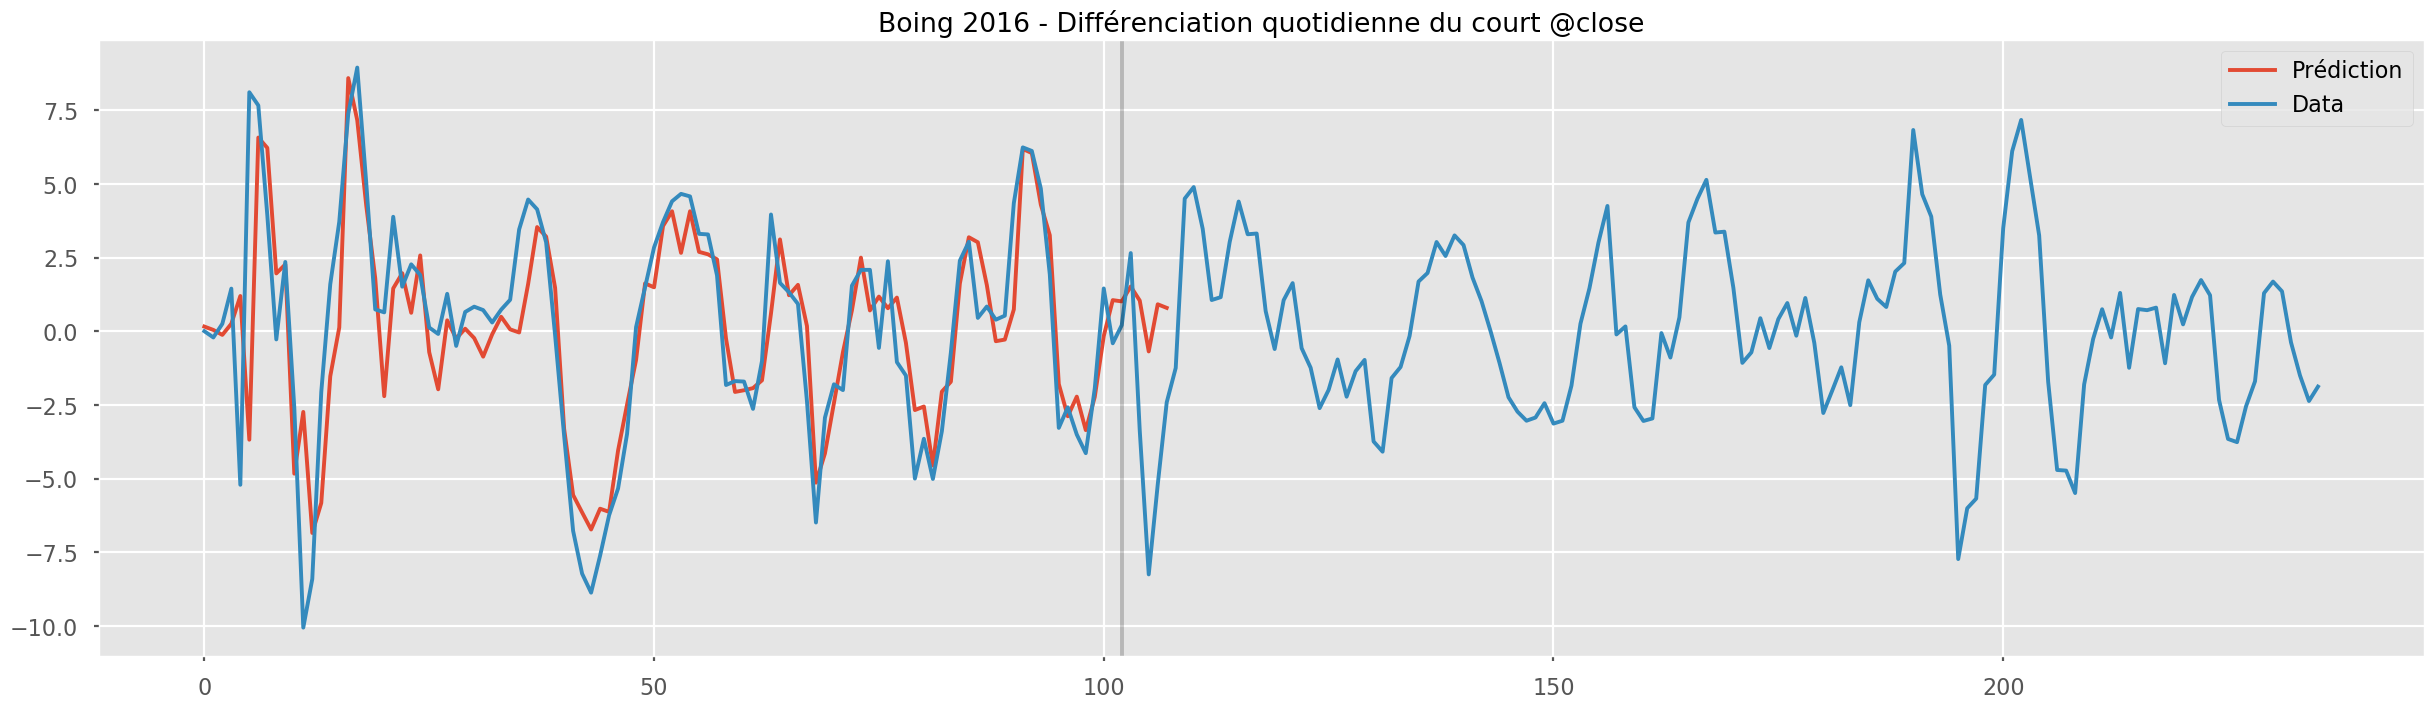

In [231]:
stpp_ARMA(BA_2016_diff5_minus_mean, trainset_end= 102, order= (1, 5), dp_pred= 5, title= 'Boing 2016 - Différenciation quotidienne du court @close' )

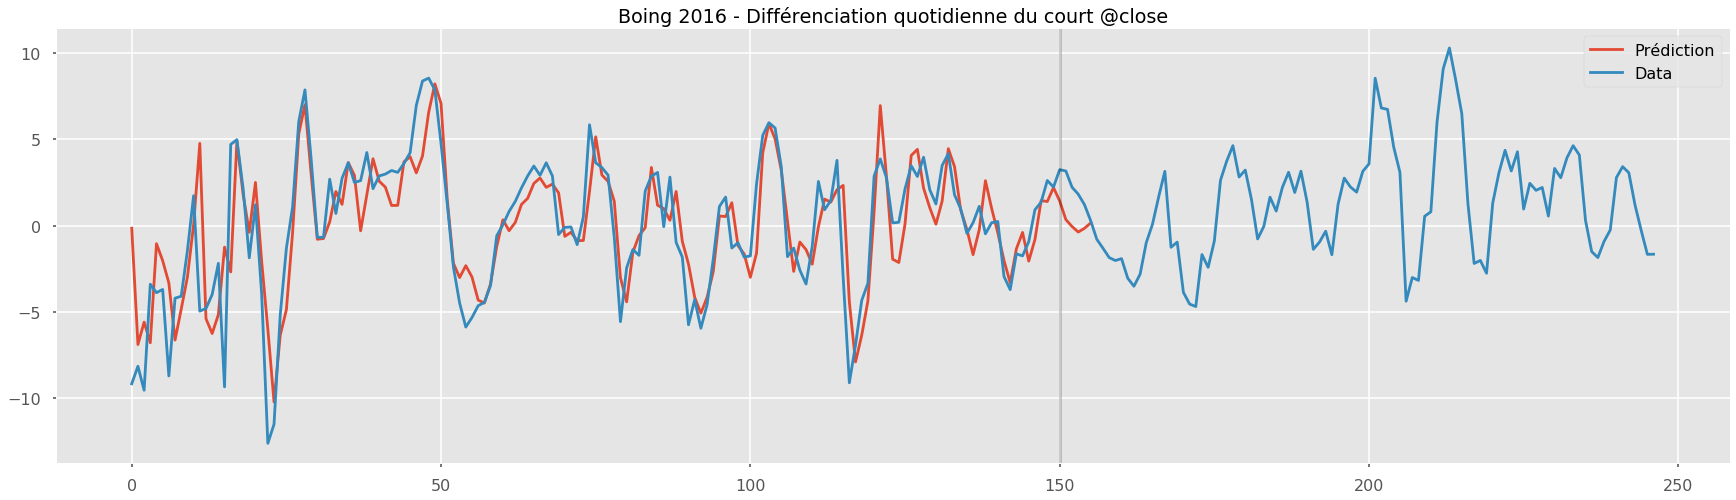

In [57]:
# no de jour dans l'année où s'arrête le training set
trainset_end = 150 

# Define training data
BA_2016_diff5_train = BA_2016_diff5.iloc[0:trainset_end]
BA_2016_diff5_train.dropna(inplace= True)

# Forecast price using an ARMA(6,3) model
mod_arma63_t = ARMA(BA_2016_diff5_train, order=(6, 3))
res_arma63_t = mod_arma63_t.fit()

# Predict 5 days after training
pred_arma63_t = res_arma63_t.predict(end= trainset_end + 5)

# Plot the original series and the forecasted series
plt.style.use("seaborn-poster")
fig= plt.figure(figsize= (30, 8))
ax= fig.add_subplot(111)
ax.set(title= 'Boing 2016 - Différenciation quotidienne du court @close')
ax.plot(pred_arma63_t, label= 'Prédiction') # Prediction
ax.plot(df, label= 'Data') # Actual data
ax.axvline(x= trainset_end, linestyle='-', color='k', alpha= 0.2) # Vertical line to mark where prediction starts
ax.legend()

_ = plt.show()

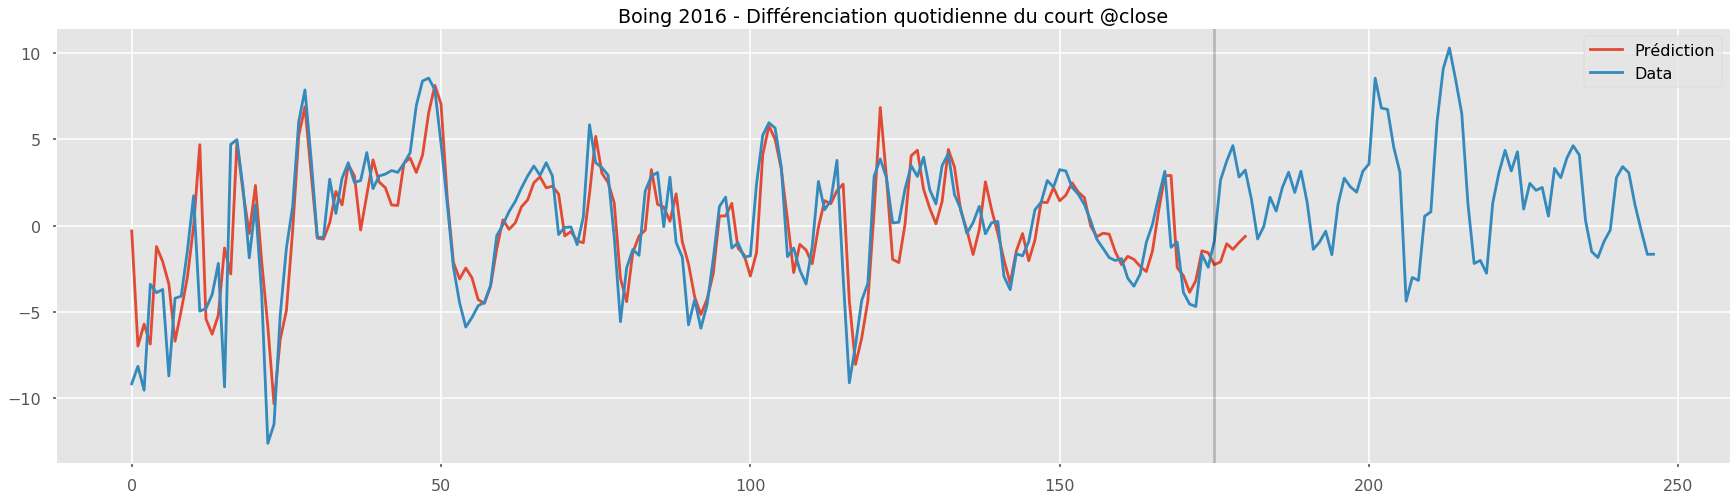

In [61]:
# no de jour dans l'année où s'arrête le training set
trainset_end = 175 

# Define training data
BA_2016_diff5_train = BA_2016_diff5.iloc[0:trainset_end]
BA_2016_diff5_train.dropna(inplace= True)

# Forecast price using an ARMA(6,3) model
mod_arma63_t = ARMA(BA_2016_diff5_train, order=(6, 3))
res_arma63_t = mod_arma63_t.fit()

# Predict 5 days after training
pred_arma63_t = res_arma63_t.predict(end= trainset_end + 5)

# Plot the original series and the forecasted series
plt.style.use("seaborn-poster")
fig= plt.figure(figsize= (30, 8))
ax= fig.add_subplot(111)
ax.set(title= 'Boing 2016 - Différenciation quotidienne du court @close')
ax.plot(pred_arma63_t, label= 'Prédiction') # Prediction
ax.plot(df, label= 'Data') # Actual data
ax.axvline(x= trainset_end, linestyle='-', color='k', alpha= 0.2) # Vertical line to mark where prediction starts
ax.legend()

_ = plt.show()

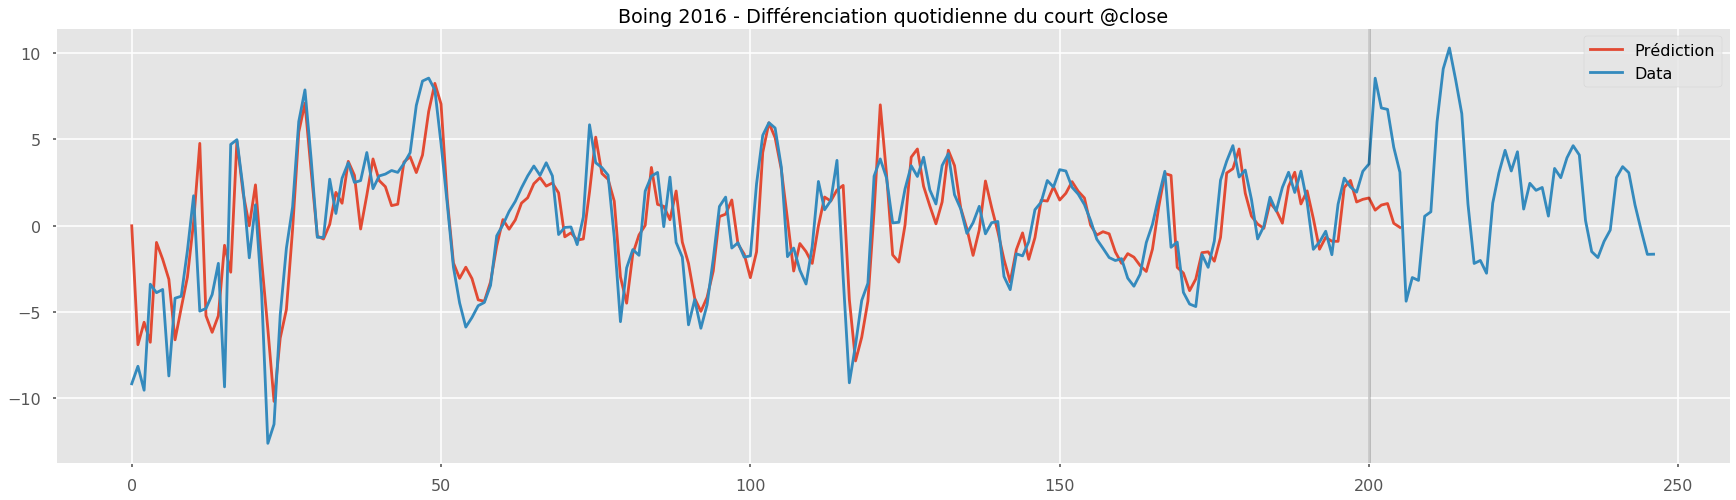

In [56]:
# no de jour dans l'année où s'arrête le training set
trainset_end = 200 

# Define training data
BA_2016_diff5_train = BA_2016_diff5.iloc[0:trainset_end]
BA_2016_diff5_train.dropna(inplace= True)

# Forecast price using an ARMA(6,3) model
mod_arma63_t = ARMA(BA_2016_diff5_train, order=(6, 3))
res_arma63_t = mod_arma63_t.fit()

# Predict 5 days after training
pred_arma63_t = res_arma63_t.predict(end= trainset_end + 5)

# Plot the original series and the forecasted series
plt.style.use("seaborn-poster")
fig= plt.figure(figsize= (30, 8))
ax= fig.add_subplot(111)
ax.set(title= 'Boing 2016 - Différenciation quotidienne du court @close')
ax.plot(pred_arma63_t, label= 'Prédiction') # Prediction
ax.plot(df, label= 'Data') # Actual data
ax.axvline(x= trainset_end, linestyle='-', color='k', alpha= 0.2) # Vertical line to mark where prediction starts
ax.legend()

_ = plt.show()

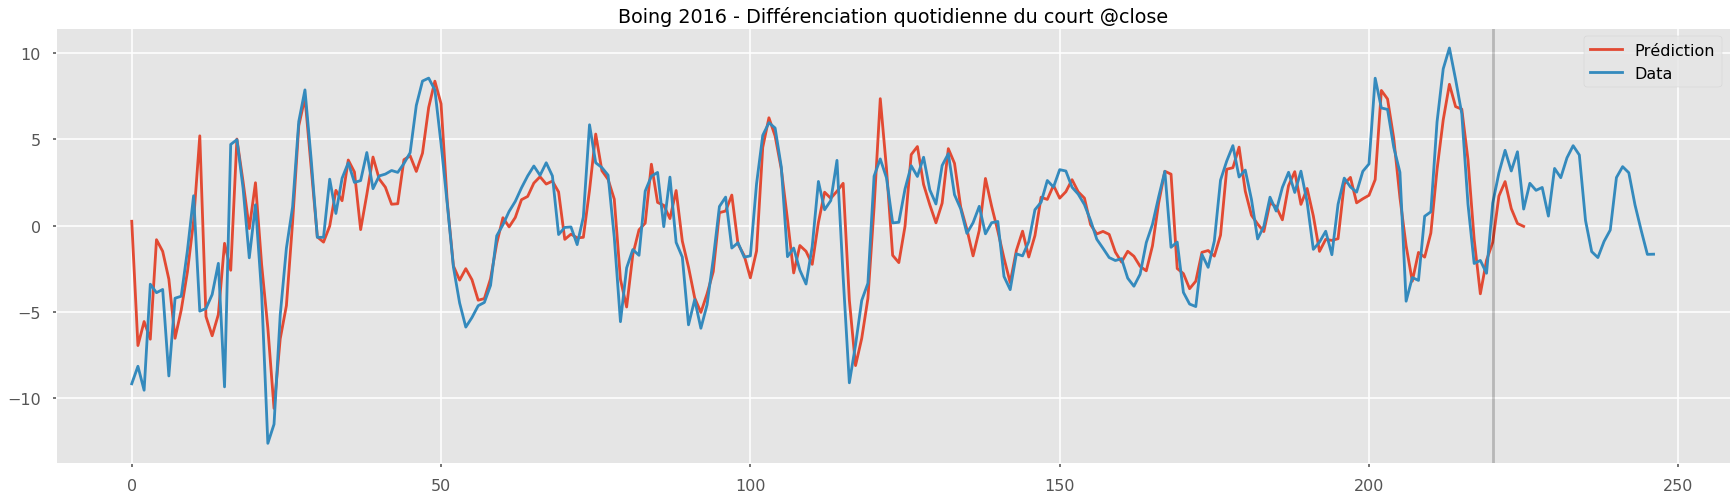

In [58]:
# no de jour dans l'année où s'arrête le training set
trainset_end = 220 

# Define training data
BA_2016_diff5_train = BA_2016_diff5.iloc[0:trainset_end]
BA_2016_diff5_train.dropna(inplace= True)

# Forecast price using an ARMA(6,3) model
mod_arma63_t = ARMA(BA_2016_diff5_train, order=(6, 3))
res_arma63_t = mod_arma63_t.fit()

# Predict 5 days after training
pred_arma63_t = res_arma63_t.predict(end= trainset_end + 5)

# Plot the original series and the forecasted series
plt.style.use("seaborn-poster")
fig= plt.figure(figsize= (30, 8))
ax= fig.add_subplot(111)
ax.set(title= 'Boing 2016 - Différenciation quotidienne du court @close')
ax.plot(pred_arma63_t, label= 'Prédiction') # Prediction
ax.plot(df, label= 'Data') # Actual data
ax.axvline(x= trainset_end, linestyle='-', color='k', alpha= 0.2) # Vertical line to mark where prediction starts
ax.legend()

_ = plt.show()

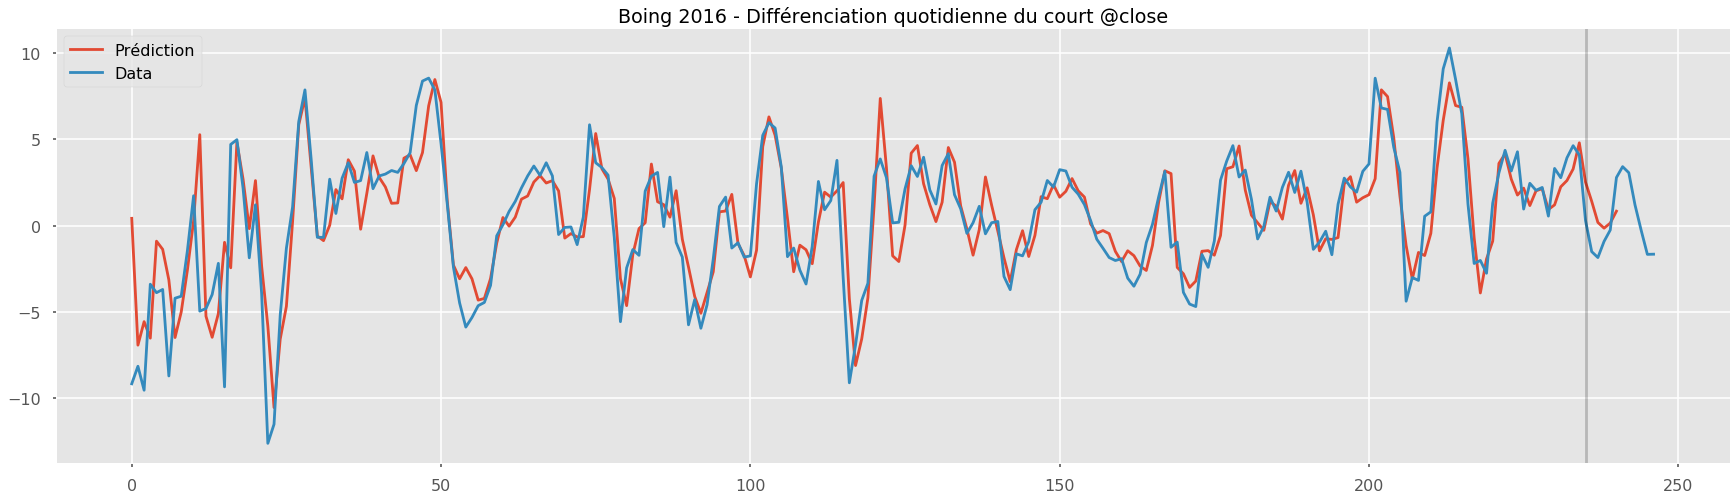

In [59]:
# no de jour dans l'année où s'arrête le training set
trainset_end = 235 

# Define training data
BA_2016_diff5_train = BA_2016_diff5.iloc[0:trainset_end]
BA_2016_diff5_train.dropna(inplace= True)

# Forecast price using an ARMA(6,3) model
mod_arma63_t = ARMA(BA_2016_diff5_train, order=(6, 3))
res_arma63_t = mod_arma63_t.fit()

# Predict 5 days after training
pred_arma63_t = res_arma63_t.predict(end= trainset_end + 5)

# Plot the original series and the forecasted series
plt.style.use("seaborn-poster")
fig= plt.figure(figsize= (30, 8))
ax= fig.add_subplot(111)
ax.set(title= 'Boing 2016 - Différenciation quotidienne du court @close')
ax.plot(pred_arma63_t, label= 'Prédiction') # Prediction
ax.plot(df, label= 'Data') # Actual data
ax.axvline(x= trainset_end, linestyle='-', color='k', alpha= 0.2) # Vertical line to mark where prediction starts
ax.legend()

_ = plt.show()

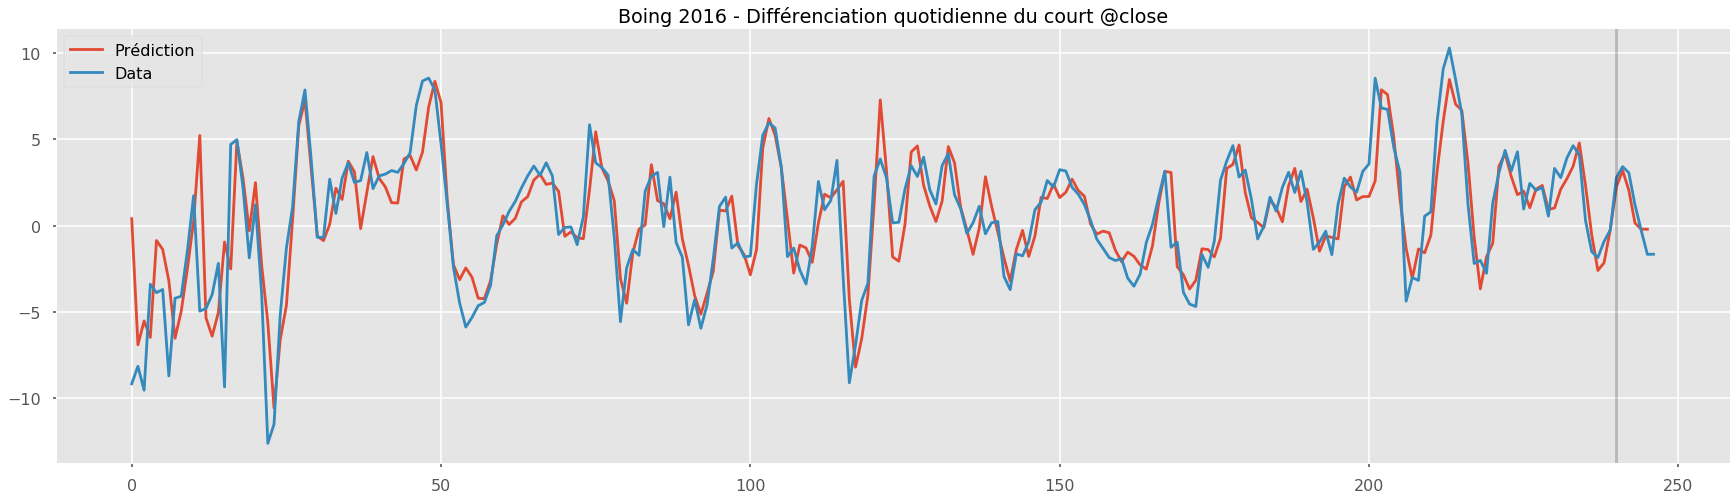

In [60]:
# no de jour dans l'année où s'arrête le training set
trainset_end = 240 

# Define training data
BA_2016_diff5_train = BA_2016_diff5.iloc[0:trainset_end]
BA_2016_diff5_train.dropna(inplace= True)

# Forecast price using an ARMA(6,3) model
mod_arma63_t = ARMA(BA_2016_diff5_train, order=(6, 3))
res_arma63_t = mod_arma63_t.fit()

# Predict 5 days after training
pred_arma63_t = res_arma63_t.predict(end= trainset_end + 5)

# Plot the original series and the forecasted series
plt.style.use("seaborn-poster")
fig= plt.figure(figsize= (30, 8))
ax= fig.add_subplot(111)
ax.set(title= 'Boing 2016 - Différenciation quotidienne du court @close')
ax.plot(pred_arma63_t, label= 'Prédiction') # Prediction
ax.plot(df, label= 'Data') # Actual data
ax.axvline(x= trainset_end, linestyle='-', color='k', alpha= 0.2) # Vertical line to mark where prediction starts
ax.legend()

_ = plt.show()

In [288]:
pred_arma63_t[0]

-0.3062929206451148

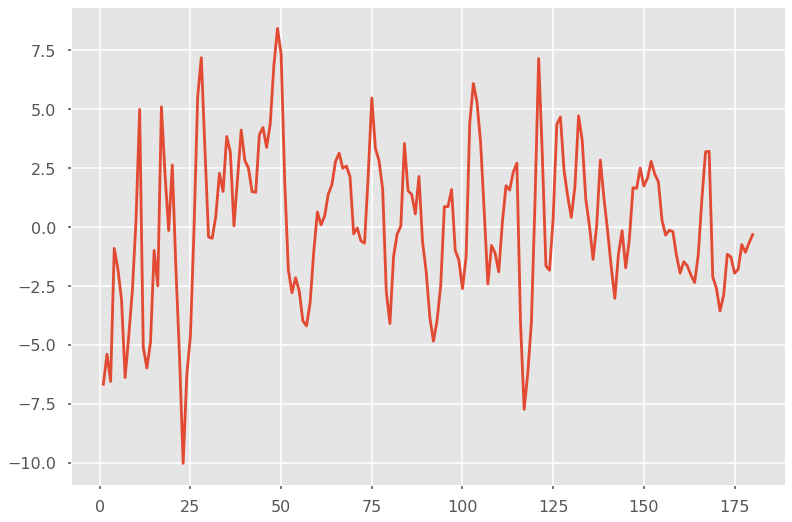

In [69]:
diff_forecast = pred_arma63_t.diff()
mean_forecast = np.cumsum(diff_forecast)
_ = plt.plot(mean_forecast)

In [135]:
BA_2016['Adj Close'][-1]

144.33763100000002

In [128]:
#BA_2017 = BA.loc['2017']
BA_2017_janv = BA.loc['2017-01']

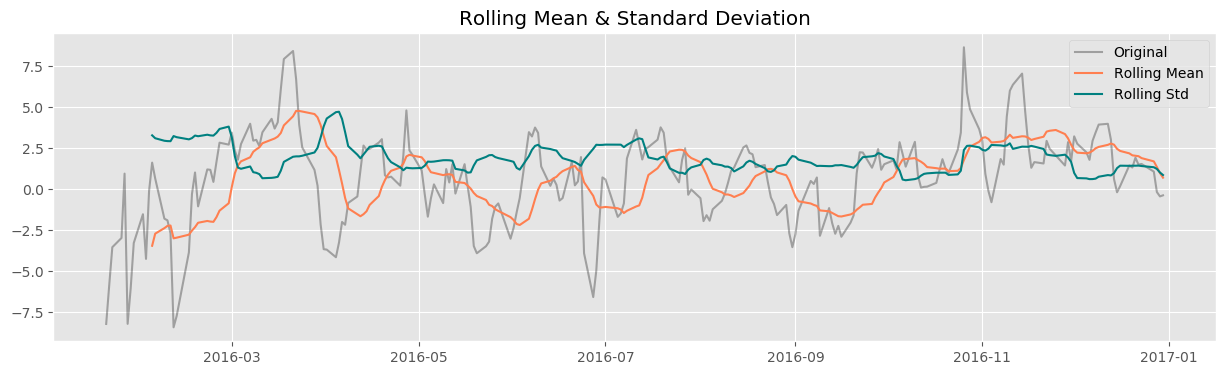

Mean MinMax Delta: 8.239565104166655
Std MinMax Delta: 4.185307696236773
ADF Statistic: -5.469649906370826
p-value: 2.4147273585294137e-06
Critical Values:
	1%: -3.458010773719797
	5%: -2.8737103617125186
	10%: -2.5732559963936206


In [128]:
# Stationarisation transformation by subtracting the rolling average 
# (https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7)
BA_2016_ravg = BA_2016['Adj Close'].rolling(12).mean()
BA_2016_minus_mean = BA_2016['Adj Close'] - BA_2016_ravg
BA_2016_minus_mean.dropna(inplace=True)

get_stationarity(BA_2016_minus_mean)

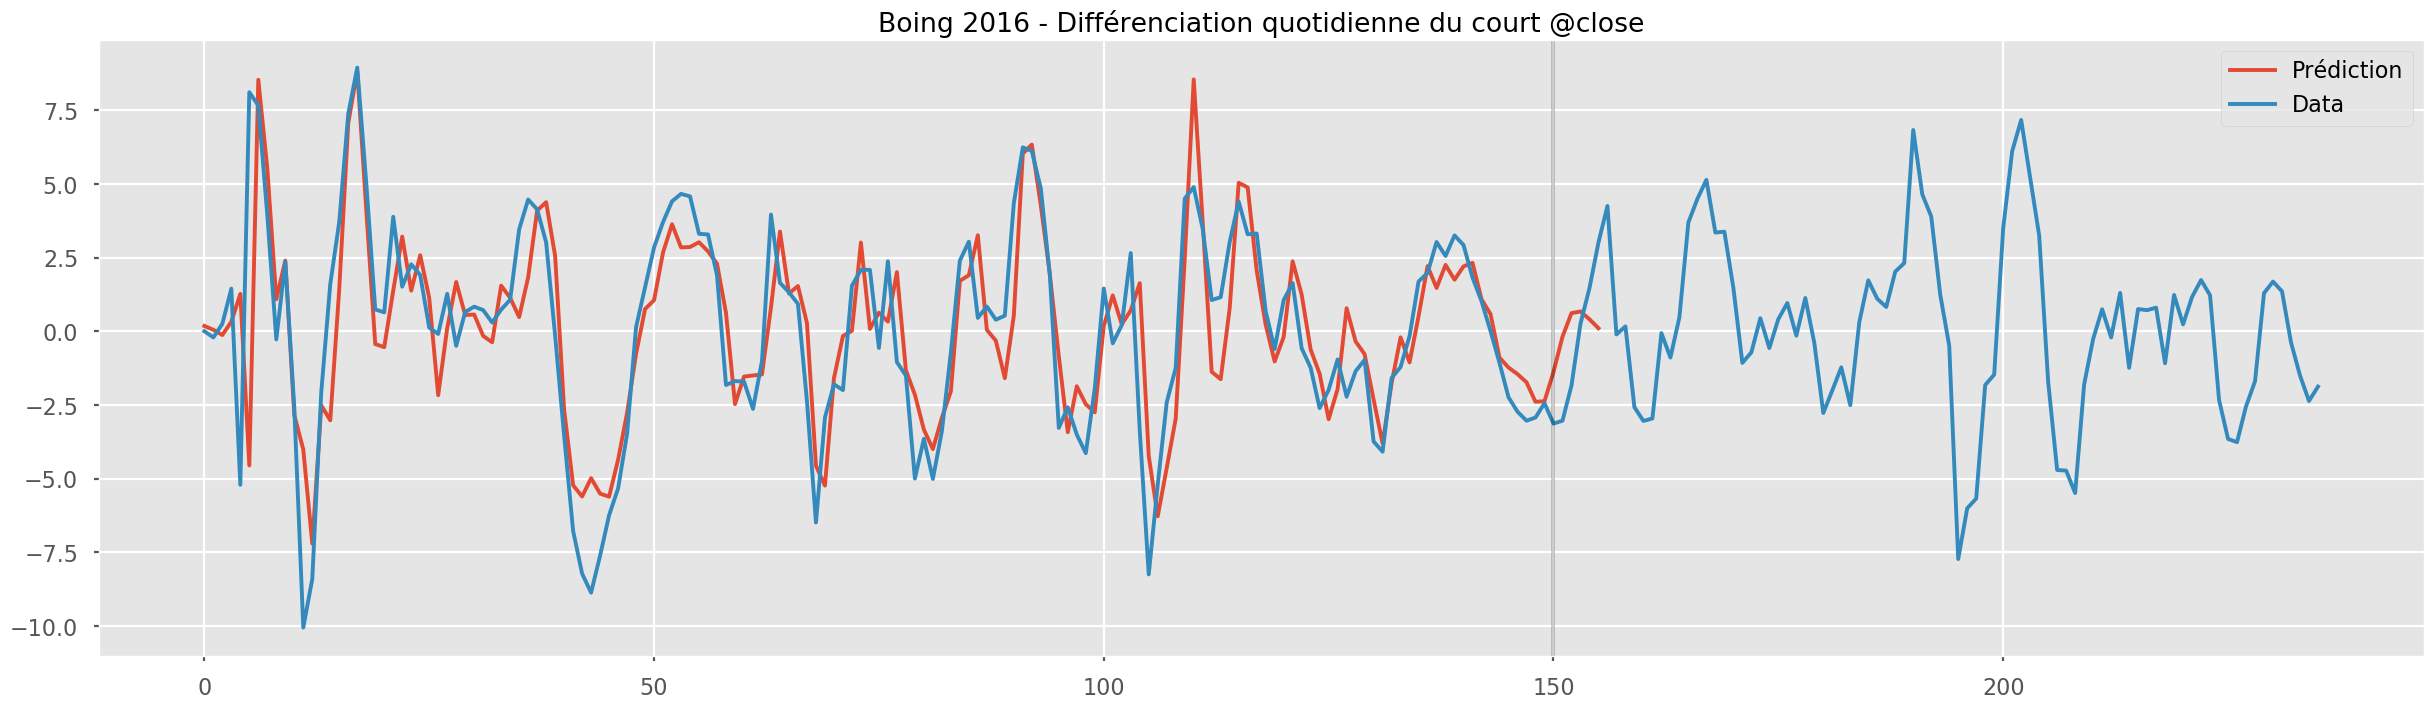

In [140]:
stpp(BA_2016_diff5_minus_mean, trainset_end= 150, order= (6,3), dp_pred= 5 )

In [71]:
BA_2016.index = pd.DatetimeIndex(BA_2016.index).to_period('D') # Nécessaire pour forcaster

ValueError: The start index -2 of the original series  has been differenced away

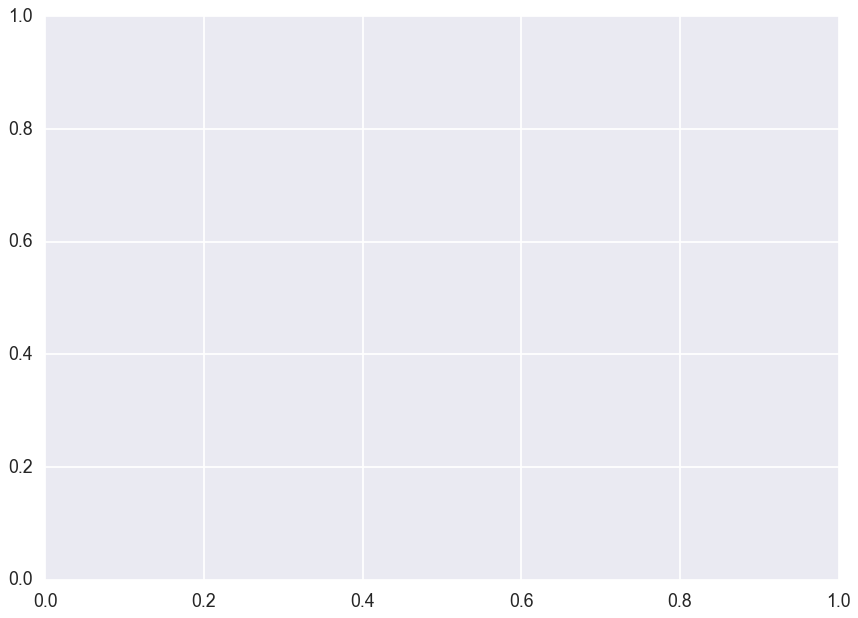

In [115]:
# Forecast price using an ARIMA(6,1,3) model
BA_2016_adj = BA_2016['Adj Close']
mod_arima63 = ARIMA(BA_2016_adj, order=(6, 2, 3))
res_arima63 = mod_arima63.fit()

# Plot the original series and the forecasted series
res_arima63.plot_predict(start=0, end=260)
plt.show()

In [122]:
BA_2016_adj.shape

(252,)

## Boing hors crise (2015 à 2019)

In [117]:
BA_nonCrisis = BA.loc['2016': '2019']

In [48]:
BA_nonCrisis.head()

Date
2016-01-05    0.507286
2016-01-06   -1.993507
2016-01-07   -5.179581
2016-01-08   -2.687652
2016-01-11    0.195808
Name: Adj Close, dtype: float64

### Valeurs différenciées sur interval de 1 jours ("First difference")

In [118]:
BA_nonCrisis1 = BA_nonCrisis['Adj Close'].diff()
BA_nonCrisis1.dropna(inplace= True)

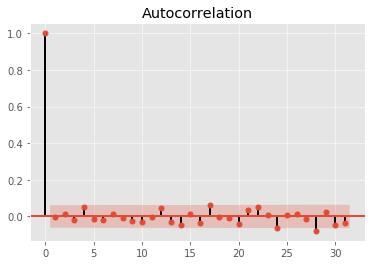

In [119]:
_ = plot_acf(BA_nonCrisis1) # _ = est un truc pour éviter d'imprimer 2x le même plot

### Valeurs différenciées sur interval de 5 jours

In [120]:
BA_nonCrisis5 = BA_nonCrisis['Adj Close'].diff(5)
BA_nonCrisis5.dropna(inplace= True)

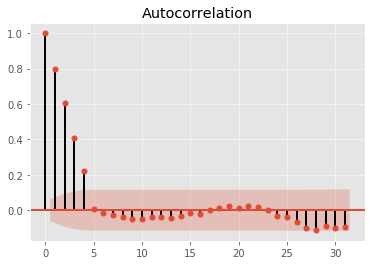

In [121]:
_ = plot_acf(BA_nonCrisis5) # _ = est un truc pour éviter d'imprimer 2x le même plo5

In [67]:
BA_nonCrisis4.autocorr()

0.7617474221452258

In [65]:
BA_nonCrisis10 = BA_nonCrisis['Adj Close'].diff(10)
BA_nonCrisis10.dropna(inplace= True)

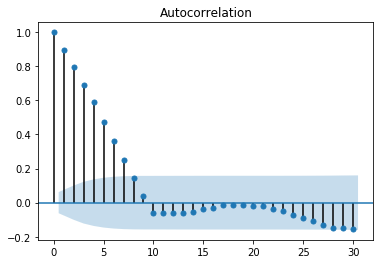

In [66]:
_ = plot_acf(BA_nonCrisis10) # _ = est un truc pour éviter d'imprimer 2x le même plot

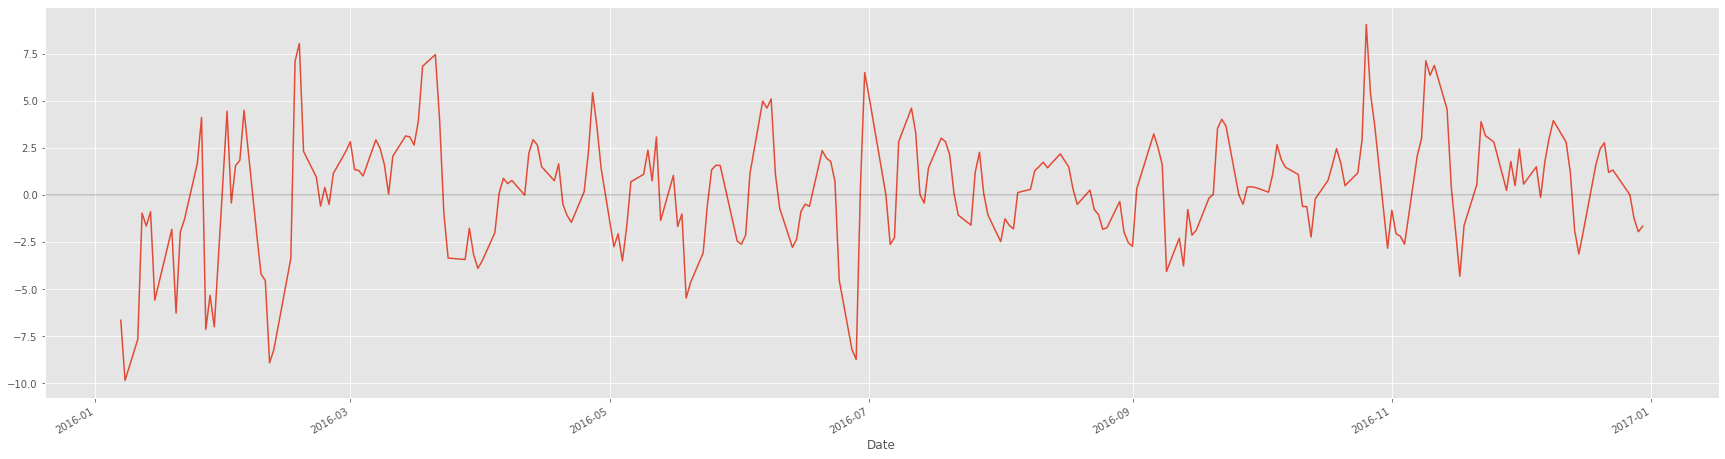

In [16]:
BA_2016_diff3 = BA_2016['Adj Close'].diff(3)
BA_2016_diff3.dropna(inplace= True)
_ = BA_2016_diff3.plot(figsize= [30, 8])
_ = plt.axhline(y= 0, linestyle='-', color='k', alpha= 0.2)

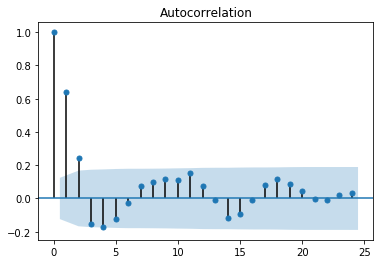

In [61]:
_ = plot_acf(BA_2016_diff3) # _ = est un truc pour éviter d'imprimer 2x le même plot

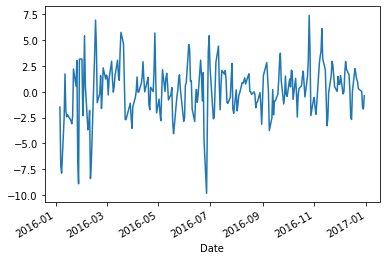

In [24]:
BA_2016_diff2 = BA_2016['Adj Close'].diff(2)
BA_2016_diff2.plot()

In [135]:
def defaultArg(name, foo='Come here!'):
    print (name,foo)
defaultArg('Joe')

Joe Come here!


In [136]:
defaultArg('Bob', foo= ', T big')

Bob , T big
